## This contains some of the initial code we used to compose our CNN for the MNIST database; once we completed and refined the CNN to an accuracy we were satisfied with we saved it into our working directory and uploaded it when we wanted to use it in our actual pipeline and for analysis; our accuracy / miscclassification analysis of our final CNN is at the bottom of this

In [1]:
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [2]:
# Format data for keras API; this data-preparation section advised by linked website
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
img_size = (28, 28, 1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print('Number of images in x_train', x_train.shape[0])
print('Number of images in x_test', x_test.shape[0])

x_train shape: (60000, 28, 28, 1)
Number of images in x_train 60000
Number of images in x_test 10000


In [3]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Activation
from keras.callbacks import EarlyStopping

#Use sequential model because based on research that is what seems like is the best for classification CNN
model = Sequential()

#Perform initial convolution. Activation just linear. 3x3 conv-> valid padding would reduce size to 26x26
#adding more filters takes longer, inc acc
#Use 3x3 because research suggested 3x3 or 5x5 and our img size was only 28x28
model.add(Conv2D(16, kernel_size=(3,3), padding="same", input_shape=img_size))

#Perform 2nd conv
#Adding more layers takes longer, inc acc
model.add(Conv2D(32, (3, 3), padding="same", activation = "relu"))
#Pooling for feature control for not perfectly aligned data set
#Use max pooling because that's what was recommended in Assignment 4 and articles suggested it
#Use pooling to downsample more robustly than stride increase
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25)) #dropout for regularization; .25 kind of arbitrary as rate of disassoc.
model.add(Conv2D(64, (3, 3), padding="same", activation = "relu"))
model.add(Dropout(0.25))

#Flatten array for fully connected layers 
model.add(Flatten())

#Do fc layer with 256 nodes; would do 14x14x64 but that had estimated training time of a day
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
#Adding another fully conn (like 128 or 64) doesnt help and makes training super long
model.add(Dense(10,activation="softmax"))

#Use adam optimizer and sparse crossentropy loss function based on research. Cross-ent better for classification
#Sparse does not require hot encoding, ie that we necessarily hardcode our 10 classes in memory
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#Stop if doesnt imporove after 3 epochs
checkImprovement = EarlyStopping(patience=3)

#Data small enough so fit_generator not rqd
model.fit(x=x_train,y=y_train, validation_split=.2, epochs=10, callbacks=[checkImprovement])

ModuleNotFoundError: No module named 'keras'

In [ ]:
#Use adam optimizer and sparse crossentropy loss function based on research. Cross-ent better for classification
#Sparse does not require hot encoding, ie that we necessarily hardcode our 10 classes in memory
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#Stop if doesnt imporove after 3 epochs
checkImprovement = EarlyStopping(patience=3)

#Data small enough so fit_generator not rqd
model.fit(x=x_train,y=y_train, validation_split=.2, epochs=10, callbacks=[checkImprovement])

In [ ]:
model.evaluate(x_test, y_test)
model.summary()

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
image_index = 4444
plt.imshow(x_test[image_index].reshape(28, 28),cmap='Greys')
pred = model.predict(x_test[image_index].reshape(1, 28, 28, 1))
print(pred.argmax())

# Our Stuff

In [4]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [5]:
one = cv2.imread(r'C:\Users\MattHetrick\Documents\Academics\Fall 2019\Cos 429\Final-Project\One.jpg')
reg1 = cv2.imread(r'C:\Users\MattHetrick\Documents\Academics\Fall 2019\Cos 429\Final-Project\New1.jpg')
flat2 = cv2.imread(r'C:\Users\MattHetrick\Documents\Academics\Fall 2019\Cos 429\Final-Project\Flat2.jpg')
two = cv2.imread(r'C:\Users\MattHetrick\Documents\Academics\Fall 2019\Cos 429\Final-Project\2.jpg')
seven = cv2.imread(r'C:\Users\MattHetrick\Documents\Academics\Fall 2019\Cos 429\Final-Project\7.jpg')
eight = cv2.imread(r'C:\Users\MattHetrick\Documents\Academics\Fall 2019\Cos 429\Final-Project\8.jpg')

In [6]:
def predictNumber(img):
    imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    squareGray = imgGray[1000:3500, 0:2500] #square size depends on img but worked for all sample images

    resizedSquare = cv2.resize(squareGray, (28, 28), interpolation=cv2.INTER_AREA)

    #format for keras
    squareAsArray = resizedSquare.reshape(28, 28, 1)
    squareAsArray = squareAsArray.astype('float32')

    #make all black and white, black number
    squareAsArray[squareAsArray <= 180.] = 255.
    squareAsArray[squareAsArray < 255.] = 0.

    #format for keras (again)
    squareAsArray /= 255
    predictionImage = squareAsArray.reshape(1, 28, 28, 1)
    
    #visualize image
    #plt.imshow(predictionImage.reshape(28,28), cmap = "Greys")

    pred = model.predict(predictionImage)
    
    return pred.argmax()

In [7]:
predictNumber(two)

error: OpenCV(3.4.2) /opt/concourse/worker/volumes/live/9523d527-1b9e-48e0-7ed0-a36adde286f0/volume/opencv-suite_1535558719691/work/modules/imgproc/src/color.hpp:253: error: (-215:Assertion failed) VScn::contains(scn) && VDcn::contains(dcn) && VDepth::contains(depth) in function 'CvtHelper'


# input model and perform misclassification analysis

In [5]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.models import load_model
from keras import activations, initializers, regularizers, constraints

In [6]:
model = load_model("Model_3conv.h5", custom_objects = {'softmax_v2': tf.nn.softmax})

In [8]:
model.evaluate(x_test, y_test)
#model.summary()

10000/10000 [==============================] - 1s 145us/step


[0.03472121387043682, 0.9922000169754028]

In [9]:
predicted = model.predict(x_test) 
pred_class = np.argmax(predicted, 1)

In [30]:
diff = np.absolute(y_test - pred_class)

Misclassified label = 7 || correct label =  9


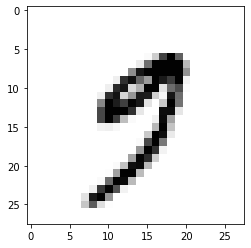

In [91]:
num = 2582
plt.imshow(x_test[num].reshape(28, 28),cmap='Greys')
print("Misclassified label =",pred_class[num], "|| correct label = ",y_test[num])

In [39]:
missclassified = []
misclassified_diff = []

for i in range(0,diff.size):
    if (diff[i] > 0):
        missclassified.append(i)
        misclassified_diff.append(diff[i])
        cv